In [1]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import numpy as np
from matplotlib.pylab import plt

from models.mtcnn import detect_faces, show_bboxes
from models.face_parsing import seg_faces

### 1. Target Image

In [2]:
# img = Image.open('samples/trot.png')
# Image.fromarray(np.asarray(img)[:,:,:3]).save("samples/trot.jpg")

In [3]:
# Get BBoxs
img = Image.open('samples/v.jpg')
bboxs, landmarks = detect_faces(img)

# Convert to Nuki Boxs
nboxs = []
for bbox in bboxs:
    x0, y0, x1, y1 = bbox[:4]
    xc = (x0+x1)/2
    yc = (y0+y1)/2
    wr = (x1-x0)/2 * 2
    hr = (y1-y0)/2 * 2
    nboxs.append((
        int(max(0, xc-wr)), 
        int(max(0, yc-hr)), 
        int(min(xc+wr, img.size[0])), 
        int(min(yc+hr, img.size[1]))
    ))
    
masks = seg_faces(img, nboxs)


In [4]:
masks = (np.array(masks) > 0) & (np.array(masks) != 14) & (np.array(masks) != 16)

In [5]:
# masks = np.array(masks) > 1

### 2. SizeUp Head

In [6]:
orig_img = np.asarray(img)
result_img = np.asarray(img).copy()

zip_list = zip(nboxs, masks)
zip_list = sorted(zip_list, key=lambda x : x[1].sum())
for nbox, mask in zip_list:    
    # original size
    x0,y0,x1,y1 = nbox[:4]
    xc = int((x0+x1)/2)
    yc = int((y0+y1)/2)
    w = x1-x0
    h = y1-y0
    
    # size ratio
    sr = 1.5
    
    face_img = orig_img[y0:y1, x0:x1, :]
    face_img = Image.fromarray(face_img)
    mask = Image.fromarray(mask.astype(np.uint8))
    
    face_img = face_img.resize((int(w*sr), int(h*sr)))
    mask = mask.resize((int(w*sr), int(h*sr)))
    
    face_img = np.asarray(face_img).copy()
    mask = np.asarray(mask)
    mask = np.expand_dims(mask, 2)
    face_img *= mask

    # new size
    nw = face_img.shape[1]
    nh = face_img.shape[0]
    for row in range(face_img.shape[0]):
        srow = row+yc+int(h/2-nh)
        if srow < 0 or srow >= result_img.shape[0]:
            continue
        for col in range(face_img.shape[1]):
            scol = col+xc-int(nw/2)
            if scol < 0 or scol >= result_img.shape[1]:
                continue
            
            if np.sum(face_img[row][col]) == 0:
                continue
                
            result_img[srow][scol] = face_img[row][col]
        
    
    

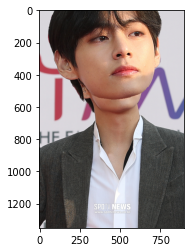

In [7]:
plt.imshow(result_img)
Image.fromarray(result_img).save("results/result_bighead_seg.png")

# Key matchings

- 0: background   
- 1: face   
- 2: left eyebrow
- 3: right eyebrow
- 4: 왼쪽눈?
- 5: 오른쪽눈?
- 6: glasses 
- 7: left ear   
- 8: right ear   
- 9: 귀걸이??
- 10: nose   
- 11: mouth   
- 12: upper lip  
- 13: under lip
- 14: neck   
- 15: 목걸이??
- 16: shoulder
- 17: hair   
